In [1]:
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential, layers, regularizers
from tensorflow.keras.layers import Dense, Dropout, LSTM, Conv1D, Lambda, BatchNormalization, Bidirectional

In [3]:
yf.pdr_override()
pd.options.display.float_format = '{:.4f}'.format
pd.set_option('display.max_columns', None)
def get_adj_price_data(x):
    df_price = pd.DataFrame(columns=x)
    for ticker in x:
        df_price[ticker] = pdr.get_data_yahoo(ticker, start = start_date, end = end_date)['Close']
    return df_price.dropna(axis=0)

# 변수 수정해주세요
#stock_list = ['ES=F','YM=F','NQ=F','^RUT' ,'CL=F', 'GC=F', 'SI=F', 'EURUSD=X','^FVX', '^TNX','AMD','HG=F','PL=F','PA=F','AAPL','nvda']
stock_list = ['ES=F', '^RUT', 'CL=F', 'GC=F', '^FVX', 'AMD', 'HG=F', 'PA=F', 'nvda']
start_date = "2017-01-01"
end_date = "2022-01-01"


df_stock_list = get_adj_price_data(stock_list)

df_intel = pdr.get_data_yahoo("INTC", start = start_date, end = end_date) #인텔
df_intel.drop(['Adj Close'], axis=1, inplace=True)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
#컬럼 이름변경
#df_stock_list.columns = ['sp500','dow','nsd','russell', 'oil', 'gold', 'silver', 'usd','fyear', 'tyear', 'amd', 'copper', 'plati', 'palla', 'appl', 'nvda']
df_stock_list.columns = ['ES=F', '^RUT', 'CL=F', 'GC=F', '^FVX', 'AMD', 'HG=F', 'PA=F', 'nvda']

In [5]:
# df_intel과 df_stock_list 를 조인
data = pd.merge(df_stock_list, df_intel, left_on='Date', right_on='Date', how='inner')
#데이터 확인
data.head()

,ES=F,^RUT,CL=F,GC=F,^FVX,AMD,HG=F,PA=F,nvda,Open,High,Low,Close,Volume
Date,,,,,,,,,,,,,,
2017-01-03,2252.5000,1365.4900,52.3300,1160.4000,1.9440,11.4300,2.4810,709.3000,25.5025,36.6100,36.9300,36.2700,36.6000,20196500
2017-01-04,2264.2500,1387.9500,53.2600,1163.8000,1.9470,11.4300,2.5480,738.2000,26.0975,36.7100,36.7700,36.3400,36.4100,15915700
2017-01-05,2264.2500,1371.9399,53.7600,1179.7000,1.8630,11.2400,2.5295,737.6000,25.4350,36.4500,36.7200,36.3100,36.3500,13986000
2017-01-06,2271.5000,1367.2800,53.9900,1171.9000,1.9220,11.3200,2.5380,757.7500,25.7750,36.5900,36.6800,36.1900,36.4800,15114000
2017-01-09,2265.0000,1357.4900,51.9600,1183.5000,1.8810,11.4900,2.5300,756.5500,26.8200,36.4800,36.8900,36.4800,36.6100,19461400


In [6]:
print(data)
print(type(data))
data.describe()

                ES=F      ^RUT    CL=F      GC=F   ^FVX      AMD   HG=F  \
Date                                                                      
2017-01-03 2252.5000 1365.4900 52.3300 1160.4000 1.9440  11.4300 2.4810   
2017-01-04 2264.2500 1387.9500 53.2600 1163.8000 1.9470  11.4300 2.5480   
2017-01-05 2264.2500 1371.9399 53.7600 1179.7000 1.8630  11.2400 2.5295   
2017-01-06 2271.5000 1367.2800 53.9900 1171.9000 1.9220  11.3200 2.5380   
2017-01-09 2265.0000 1357.4900 51.9600 1183.5000 1.8810  11.4900 2.5300   
...              ...       ...     ...       ...    ...      ...    ...   
2021-12-27 4782.2500 2261.4600 75.5700 1808.1000 1.2520 154.3600 4.4650   
2021-12-28 4778.5000 2246.5100 75.9800 1810.2000 1.2450 153.1500 4.4200   
2021-12-29 4784.5000 2249.2400 76.5600 1805.1000 1.2940 148.2600 4.4020   
2021-12-30 4772.2500 2248.7900 76.9900 1812.7000 1.2740 145.1500 4.3845   
2021-12-31 4758.5000 2245.3101 75.2100 1827.5000 1.2630 143.9000 4.4550   

                PA=F    

,ES=F,^RUT,CL=F,GC=F,^FVX,AMD,HG=F,PA=F,nvda,Open,High,Low,Close,Volume
count,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000,1243.0000
mean,3113.2713,1661.1971,55.9512,1497.0225,1.5994,45.1512,3.0931,1593.8864,86.4065,49.7070,50.2756,49.1538,49.7192,27077939.2599
std,661.1392,314.7819,12.7108,253.6144,0.8557,36.2522,0.6268,635.9681,65.8590,7.9409,8.0840,7.7941,7.9413,13807185.2766
min,2220.5000,991.1600,-37.6300,1160.4000,0.1950,9.5300,2.1195,709.3000,23.8725,33.2500,33.7400,33.2300,33.4600,6313200.0000
25%,2652.3750,1467.4550,48.8000,1275.3500,0.8020,13.8500,2.6600,985.4750,42.1325,45.7250,46.1950,45.1800,45.6100,18773300.0000
50%,2889.7500,1557.3300,56.3500,1404.6000,1.7470,30.2300,2.8870,1506.6000,59.7800,50.0000,50.8100,49.4900,50.1000,23593000.0000
75%,3388.3750,1696.3199,65.0650,1770.6000,2.3145,78.0600,3.1888,2176.6500,126.6325,54.9250,55.6650,54.3900,55.1650,31109200.0000
max,4784.5000,2442.7400,84.6500,2051.5000,3.0900,161.9100,4.7785,2985.3999,333.7600,68.2000,69.2900,67.3100,68.4700,182269900.0000


In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1243 entries, 2017-01-03 to 2021-12-31
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ES=F    1243 non-null   float64
 1   ^RUT    1243 non-null   float64
 2   CL=F    1243 non-null   float64
 3   GC=F    1243 non-null   float64
 4   ^FVX    1243 non-null   float64
 5   AMD     1243 non-null   float64
 6   HG=F    1243 non-null   float64
 7   PA=F    1243 non-null   float64
 8   nvda    1243 non-null   float64
 9   Open    1243 non-null   float64
 10  High    1243 non-null   float64
 11  Low     1243 non-null   float64
 12  Close   1243 non-null   float64
 13  Volume  1243 non-null   int64  
dtypes: float64(13), int64(1)
memory usage: 145.7 KB


In [8]:
data.isnull().sum()

ES=F      0
^RUT      0
CL=F      0
GC=F      0
^FVX      0
AMD       0
HG=F      0
PA=F      0
nvda      0
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [9]:
X = data.drop(['Close'], axis=1)
y = data['Close']
y = pd.DataFrame(y)

y

,Close
Date,
2017-01-03,36.6000
2017-01-04,36.4100
2017-01-05,36.3500
2017-01-06,36.4800
2017-01-09,36.6100
...,...
2021-12-27,51.9400
2021-12-28,51.7600
2021-12-29,51.8300


In [10]:
X_train = X.loc[X.index < '2021-01-01',:]
X_test = X.loc[X.index >= '2021-01-01',:]

print(X_train.shape)
print(X_test.shape)

(1001, 13)
(242, 13)


In [11]:
y_train = y.loc[y.index < '2021-01-01',:]
y_test = y.loc[y.index >= '2021-01-01',:]

print(y_train.shape)
print(y_test.shape)

(1001, 1)
(242, 1)


In [12]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(0,1))

# 스케일 후 columns
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


print(X_train)
print(type(X_train))
print(X_train.shape)
print('----------------------')
print(X_test)
print(type(X_test))
print(X_test.shape)

[[0.02093898 0.36845681 0.78884601 ... 0.08973273 0.08920191 0.0789018 ]
 [0.02862752 0.39056438 0.79700101 ... 0.08523204 0.09125589 0.05457309]
 [0.02862752 0.37480557 0.80138544 ... 0.08382559 0.09037565 0.04360618]
 ...
 [0.98118763 0.95300905 0.75087686 ... 0.47623057 0.38908459 0.44453096]
 [0.98396859 0.97331537 0.75438442 ... 0.43459908 0.44982402 0.17659004]
 [1.         0.96826585 0.75543667 ... 0.46272848 0.45451886 0.12652886]]
<class 'numpy.ndarray'>
(1001, 13)
----------------------
[[0.96302961 0.93977012 0.74754469 ... 0.49648377 0.47447192 0.2261312 ]
 [0.98004253 0.97244917 0.76780075 ... 0.48073138 0.47241794 0.10544299]
 [0.99460167 1.05002259 0.77393896 ... 0.51786217 0.49794607 0.17331764]
 ...
 [1.67773597 1.23834086 1.00131527 ... 0.51758082 0.54078643 0.04467917]
 [1.66972027 1.23789797 1.00508588 ... 0.51758082 0.54049305 0.06846116]
 [1.66072305 1.23447259 0.98947734 ... 0.51814342 0.53491786 0.05686513]]
<class 'numpy.ndarray'>
(242, 13)


In [13]:
WINDOW_SIZE=50
BATCH_SIZE=32

In [14]:
def windowed_dataset(x,y, window_size, batch_size, shuffle):
    # x 값
    ds_x = tf.data.Dataset.from_tensor_slices(x)
    ds_x = ds_x.window(WINDOW_SIZE, stride=1, shift=1, drop_remainder=True)
    ds_x = ds_x.flat_map(lambda x: x.batch(WINDOW_SIZE))
    # y 값
    ds_y = tf.data.Dataset.from_tensor_slices(y[WINDOW_SIZE:])
    ds = tf.data.Dataset.zip((ds_x, ds_y))
    if shuffle:
        ds = ds.shuffle(1000)
    return ds.batch(batch_size).prefetch(1)

In [15]:
train_data = windowed_dataset(X_train, y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(X_test, y_test, WINDOW_SIZE, BATCH_SIZE, False)

--------------양방향 LSTM --------------------

In [16]:
# LSTM

model = Sequential([
    Conv1D(filters=64, kernel_size=13,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 13])])

model.add(Bidirectional(LSTM(403, return_sequences=True,kernel_regularizer=regularizers.l2(0.01), 
                             activation = 'tanh')))
model.add(LSTM(256, activation = 'tanh'))
model.add(Dropout(rate=0.1))
model.add(Dense(32, activation='relu'))
model.add(Dense(8, activation='relu'))

model.add(Dense(1))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 50, 64)            10880     
                                                                 
 bidirectional (Bidirectiona  (None, 50, 806)          1508832   
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 256)               1088512   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense (Dense)               (None, 32)                8224      
                                                                 
 dense_1 (Dense)             (None, 8)                 264       
                                                        

In [17]:
#model1.add(Bidirectional(LSTM(128, dropout=0.1)))
#model1.add(Bidirectional(LSTM(64, dropout=0.1)))

In [18]:
model.compile(loss = 'mean_squared_error', optimizer = 'adam', metrics=[tf.keras.metrics.RootMeanSquaredError(), 'mae'])

In [19]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

es = EarlyStopping(monitor='loss', mode = 'min',patience=15)

epochs = 200
batch_size = 32
filename = 'LSTM_model_w.dropout_epoch-{}-batch-{}.h5'.format(epochs, batch_size)

checkpoint = ModelCheckpoint(filename, monitor='loss',save_best_only=True)

history = model.fit(train_data, epochs=epochs, batch_size=batch_size, callbacks=[es, checkpoint])

Epoch 1/200
30/30 [==============================] - 10s 132ms/step - loss: 631.4841 - root_mean_squared_error: 25.0890 - mae: 20.4061
Epoch 2/200
30/30 [==============================] - 3s 82ms/step - loss: 74.3713 - root_mean_squared_error: 8.5382 - mae: 6.6951
Epoch 3/200
30/30 [==============================] - 3s 83ms/step - loss: 60.9005 - root_mean_squared_error: 7.7266 - mae: 5.9988
Epoch 4/200
30/30 [==============================] - 3s 82ms/step - loss: 60.7106 - root_mean_squared_error: 7.7245 - mae: 5.9885
Epoch 5/200
30/30 [==============================] - 3s 82ms/step - loss: 59.5670 - root_mean_squared_error: 7.6560 - mae: 5.9569
Epoch 6/200
30/30 [==============================] - 3s 82ms/step - loss: 58.6038 - root_mean_squared_error: 7.5954 - mae: 5.9040
Epoch 7/200
30/30 [==============================] - 3s 83ms/step - loss: 54.6767 - root_mean_squared_error: 7.3327 - mae: 5.7078
Epoch 8/200
30/30 [==============================] - 3s 81ms/step - loss: 50.0702 - r

30/30 [==============================] - 3s 80ms/step - loss: 4.8714 - root_mean_squared_error: 2.1449 - mae: 1.6453
Epoch 64/200
30/30 [==============================] - 3s 80ms/step - loss: 4.5566 - root_mean_squared_error: 2.0700 - mae: 1.6019
Epoch 65/200
30/30 [==============================] - 3s 80ms/step - loss: 4.3672 - root_mean_squared_error: 2.0251 - mae: 1.5499
Epoch 66/200
30/30 [==============================] - 3s 76ms/step - loss: 5.2512 - root_mean_squared_error: 2.2335 - mae: 1.7146
Epoch 67/200
30/30 [==============================] - 3s 77ms/step - loss: 5.1500 - root_mean_squared_error: 2.2120 - mae: 1.6562
Epoch 68/200
30/30 [==============================] - 3s 76ms/step - loss: 4.6407 - root_mean_squared_error: 2.0939 - mae: 1.5867
Epoch 69/200
30/30 [==============================] - 3s 76ms/step - loss: 4.8168 - root_mean_squared_error: 2.1360 - mae: 1.6619
Epoch 70/200
30/30 [==============================] - 3s 80ms/step - loss: 4.3547 - root_mean_squared_e

In [20]:
pred = model.predict(test_data)
pred.shape

(192, 1)

In [21]:
print(pred)

[[60.467644]
 [60.59008 ]
 [59.721806]
 [58.806435]
 [58.78608 ]
 [59.45228 ]
 [59.957714]
 [61.218033]
 [62.04991 ]
 [62.516277]
 [62.714645]
 [62.974243]
 [62.71452 ]
 [62.399273]
 [62.115364]
 [61.61609 ]
 [61.45609 ]
 [60.911167]
 [60.03602 ]
 [59.46161 ]
 [58.809578]
 [57.084885]
 [56.81743 ]
 [56.475266]
 [56.11271 ]
 [55.941414]
 [55.09526 ]
 [55.38276 ]
 [55.291805]
 [55.702187]
 [55.344864]
 [54.07023 ]
 [52.788776]
 [52.49269 ]
 [52.821995]
 [54.006233]
 [54.729954]
 [54.477306]
 [54.838753]
 [55.567978]
 [56.133648]
 [56.44129 ]
 [56.7965  ]
 [57.10369 ]
 [57.179985]
 [56.938663]
 [57.00189 ]
 [57.118767]
 [56.978428]
 [56.989265]
 [56.82035 ]
 [56.973106]
 [56.978844]
 [57.11397 ]
 [57.053154]
 [56.877037]
 [55.708107]
 [55.863556]
 [55.783348]
 [55.947777]
 [55.860565]
 [56.181847]
 [56.43169 ]
 [56.505554]
 [56.070446]
 [56.043182]
 [56.147552]
 [55.874485]
 [56.124973]
 [55.311153]
 [55.165104]
 [55.67881 ]
 [55.987785]
 [56.048347]
 [55.489845]
 [54.536297]
 [53.288536]

In [22]:
# 모델 평가

train_metrics = model.evaluate(train_data)
test_metrics = model.evaluate(test_data)

print(train_metrics)
print(test_metrics) 

6/6 [==============================] - 0s 40ms/step - loss: 3.5637 - root_mean_squared_error: 1.8343 - mae: 1.3514
[1.9306445121765137, 1.315954566001892, 0.9383681416511536]
[3.5636940002441406, 1.8343353271484375, 1.3513613939285278]


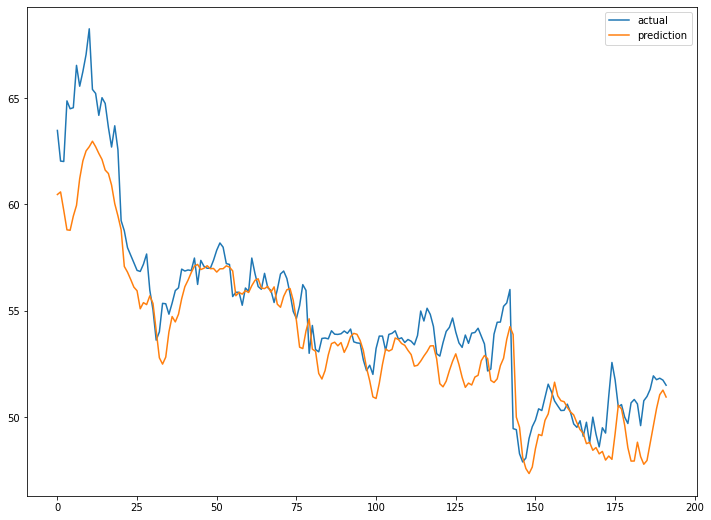

In [23]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[50:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [24]:
unscaled_y = data.iloc[-192:, -2]
y_predicted = model.predict(test_data)

col_name = ['real', 'prediction']
# real = plt.plot(np.asarray(y_test)[20:], label='actual')

real = pd.DataFrame(unscaled_y)
real = real.reset_index().iloc[:,1]
prediction = pd.DataFrame(y_predicted)

foo = pd.concat([real, prediction], axis = 1)
foo.columns = col_name
foo['real+1'] = foo['real'].shift(periods = 1)
foo.corr()

,real,prediction,real+1
real,1.0000,0.9437,0.9755
prediction,0.9437,1.0000,0.9644
real+1,0.9755,0.9644,1.0000


In [25]:
unscaled_y

Date
2021-03-23   63.4800
2021-03-24   62.0400
2021-03-25   62.0200
2021-03-26   64.8700
2021-03-29   64.5000
               ...  
2021-12-27   51.9400
2021-12-28   51.7600
2021-12-29   51.8300
2021-12-30   51.7400
2021-12-31   51.5000
Name: Close, Length: 192, dtype: float64